## 1. Xử lý thông tin các địa chỉ IP gửi request tới hệ thống
Lưu lại thông tin địa chỉ IP và số lần gửi request tương ứng dưới dạng dictionary

In [1]:
# Import thư viện regular expression
import re

# Lưu địa chỉ file log vào file_path
file_path = 'modsec_audit.log'
# Pattern của biểu thức chính quy
pattern = r'--\w+-A--\n\[[\w@ \/\:\-]+\] [\w@]+ \b((?:\d{1,3}\.){3}\d{1,3})\b'

# Khởi tạo biến dict ip_count
ip_count = {}

In [2]:
# Đọc thông tin từ file log theo cụm (mỗi cụm cách nhau bởi 1 dòng trống)
with open(file_path, 'r', encoding='latin-1') as file:
    log_text = ''
    line = file.readline()
    while line:
        if line.strip() != '':  # Kiểm tra nếu dòng không phải là dòng trống
            log_text += line
        elif log_text != '':
            matches = re.findall(pattern, log_text)
            for ip in matches:
                if ip in ip_count:
                    ip_count[ip] += 1
                else:
                    ip_count[ip] = 1
            log_text = ''
        line = file.readline()

# Kiểm tra xem có đoạn văn bản cuối cùng cần được xử lý không
if log_text != '':
    matches = re.findall(pattern, log_text)
    for ip in matches:
        if ip in ip_count:
            ip_count[ip] += 1
        else:
            ip_count[ip] = 1

# Hoàn thành lưu trữ thông tin IP và số lần gửi request tương ứng tới hệ thống trong ip_count
# print(ip_count)

{'113.190.239.186': 6, '54.36.148.99': 3, '103.131.71.162': 1, '40.77.167.60': 25, '5.161.88.42': 1, '103.153.254.110': 1279, '185.180.143.7': 7, '54.36.148.90': 3, '192.241.219.198': 2, '66.249.71.47': 18, '66.249.71.49': 5, '207.46.13.195': 34, '192.241.213.122': 1, '66.249.79.91': 14, '66.249.71.45': 33, '66.249.79.87': 27, '36.156.28.133': 9, '91.193.5.182': 1, '128.14.141.34': 29, '157.55.39.233': 8, '111.43.33.170': 3, '58.187.66.0': 1, '207.46.13.188': 13, '54.36.148.50': 2, '23.90.160.114': 3, '40.77.167.52': 18, '87.250.224.44': 13, '40.77.167.23': 10, '54.36.149.83': 1, '192.241.216.115': 1, '192.241.218.58': 3, '198.244.212.132': 1, '20.83.125.15': 1, '5.255.253.142': 2, '173.252.111.11': 1, '123.16.6.17': 3, '27.67.183.165': 1, '167.248.133.117': 5, '183.80.235.114': 1, '113.20.108.225': 1, '14.177.220.149': 1, '20.0.0.54': 13759, '66.249.79.89': 14, '152.89.196.211': 422, '113.165.166.116': 1, '125.234.97.122': 2, '59.153.243.77': 11, '115.79.138.89': 1, '64.62.197.47': 1,

## 2. Chuyển từ địa chỉ IP chuyển thành location (country)

In [3]:
# Import thư viện chuyển từ IP sang country_code
import IP2Location

# Hàm xử lý chuyển từ IP sang country_code
def get_country_code(ip_address):
    database = IP2Location.IP2Location('IPV6-COUNTRY.SAMPLE.BIN')
    result = database.get_all(ip_address)
    country_code = result.country_short
    return country_code

# Dict chứa country_code và số request tương ứng
location = {}

# Duyệt qua tất cả ip_address trong ip_count và lưu trữ trong dict location
for ip_address in ip_count:
    country_code = get_country_code(ip_address)
    if country_code in location:
        location[country_code] += ip_count[ip_address]
    else: 
        location[country_code] = ip_count[ip_address]

# print(location)


{'-': 29673, 'FR': 855, 'US': 3421, 'CN': 399, 'IT': 39, 'VN': 45894, 'NL': 1631, 'RU': 237, 'GB': 14423, 'IE': 61, 'JP': 69, 'HK': 969, 'AU': 123, 'EG': 19, 'BE': 159, 'DE': 428, 'IN': 129, 'PK': 19, 'KH': 23, 'KR': 16, 'PL': 10, 'LT': 71, 'CA': 139, 'BG': 35, 'RO': 124, 'ES': 46, 'BZ': 402, 'SG': 472, 'CH': 70, 'AE': 24, 'UZ': 67, 'UA': 14, 'LV': 4, 'BR': 16, 'ID': 15, 'SE': 66, 'PS': 5, 'FI': 135, 'MY': 9, 'PT': 11, 'NO': 79, 'CO': 1, 'HR': 11, 'TR': 33, 'TW': 81, 'SK': 15, 'GE': 9, 'AZ': 6, 'MA': 2, 'IQ': 2, 'MK': 2, 'ZA': 6, 'BA': 10, 'TF': 5, 'BH': 3, 'IR': 8, 'KE': 11, 'MW': 3, 'MD': 6, 'PH': 12, 'PA': 16, 'TH': 10, 'GR': 22, 'AL': 6, 'JO': 5, 'RS': 21, 'ZM': 4, 'IL': 2, 'DZ': 5, 'MN': 6, 'BD': 3, 'SA': 3, 'GH': 9, 'ME': 2, 'UG': 4, 'KW': 1, 'TN': 1, 'JM': 1, 'DK': 2, 'HU': 4, 'CZ': 2, 'AT': 13, 'LB': 2, 'NP': 2, 'DO': 1, 'LY': 1, 'OM': 1, 'CM': 2, 'QA': 1}


## 3. Vẽ biểu đồ

In [4]:
# Thư viện xử lý vẽ biểu đồ
import matplotlib.pyplot as plt

# Minimum counts cho các quốc gia trong biểu đồ
MINIMUM = 1000

3.1 Biểu đồ tròn

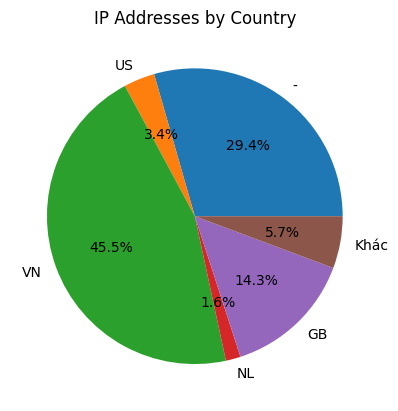

In [5]:
# Tách danh sách các quốc gia và số lượng thành hai danh sách riêng
countries = list(location.keys())
counts = list(location.values())

# Tìm các quốc gia có giá trị < MINIMUM
small_countries = [country for country, count in zip(countries, counts) if count < MINIMUM]
small_counts = [count for count in counts if count < MINIMUM]

# Tính tổng số lượng các quốc gia nhỏ (nhỏ hơn MINIMUM)
sum_small_counts = 0
for small_count in small_counts:
    sum_small_counts += small_count

# Thêm mục "Khác" vào danh sách quốc gia và số lượng
countries.append('Khác')
counts.append(sum_small_counts)

# Loại bỏ các quốc gia nhỏ từ danh sách ban đầu
countries = [country for country, count in zip(countries, counts) if count >= MINIMUM]
counts = [count for count in counts if count >= MINIMUM]

# Vẽ biểu đồ tròn
plt.pie(counts, labels=countries, autopct='%1.1f%%')

# Đặt tiêu đề cho biểu đồ
plt.title('IP Addresses by Country')

# Hiển thị biểu đồ
plt.show()


3.2 Biểu đồ cột

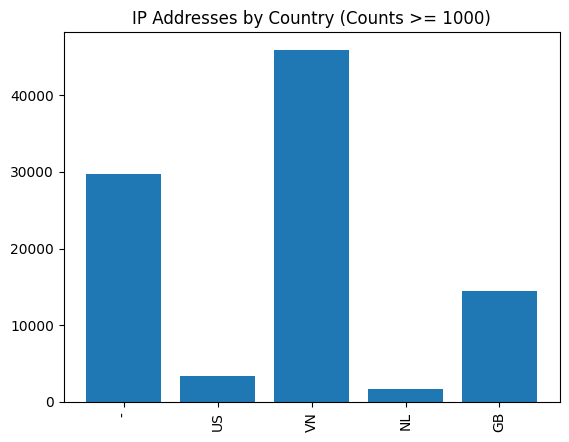

In [ ]:
# Tách danh sách các quốc gia và số lượng thành hai danh sách riêng
countries = list(location.keys())
counts = list(location.values())

# Tạo danh sách chỉ số và danh sách các nước thỏa mãn điều kiện
filtered_indexes = [i for i, count in enumerate(counts) if count >= MINIMUM]
filtered_countries = [countries[i] for i in filtered_indexes]
filtered_counts = [counts[i] for i in filtered_indexes]

# Tạo một list các chỉ số từ 0 đến độ dài của danh sách nước thỏa mãn điều kiện
x_indexes = range(len(filtered_countries))

# Vẽ biểu đồ cột
plt.bar(x_indexes, filtered_counts)

# Đặt nhãn cho trục x
plt.xticks(x_indexes, filtered_countries, rotation='vertical')

# Đặt tiêu đề cho biểu đồ
plt.title('IP Addresses by Country (Counts >= {})'.format(MINIMUM))

# Hiển thị biểu đồ
plt.show()
